In [2]:
import torch
import numpy as np
from IPython.core.debugger import set_trace
import imageio
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torch.autograd import Variable

import importlib.util


from tkmodel.TwoCUM import TwoCUMfittingConc
from tkmodel.TwoCUM import TwoCUM

In [2]:
AIF = np.load("data/AIF.npy")
t = np.arange(0,366,2.45)

series = np.load("data/Example_Conc.npy")



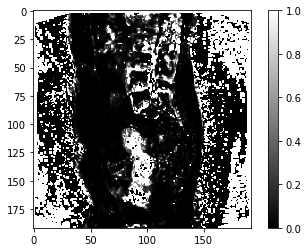

In [20]:
t = np.arange(0,366,2.45)
plt.imshow(series[:,:,15,149], cmap='gray', vmin= 0 , vmax= 1)
plt.colorbar()

In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(150, 200)   # hidden layer
        self.hidden2 = torch.nn.Linear(200, 200)   # hidden layer
        self.predict = torch.nn.Linear(200, 3)

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = F.relu(self.hidden2(x))
        x = self.predict(x)             # linear output
        return x
    
net = Net()
print(net)

Net(
  (hidden): Linear(in_features=150, out_features=200, bias=True)
  (hidden2): Linear(in_features=200, out_features=200, bias=True)
  (predict): Linear(in_features=200, out_features=3, bias=True)
)


In [22]:
#create data
#create 1000 curves
def generate_xy(num_curves):
    AIF = np.load("MRI_other/TK_Modelling/AIF.npy")
    data_size = AIF.shape[0]
    t = np.arange(0,366,2.45)

    E = np.random.rand(1,num_curves) #0 to 1 for both E and vp
    vp = np.random.rand(1,num_curves)
    Fp = abs(np.random.normal(size=num_curves, loc= 1e-5, scale = 1e-4)[None,:])

    E_Fp = np.concatenate((E, Fp), axis =0)
    y = np.concatenate((E_Fp, vp), axis =0)

    fitted_data2=[0.999999999987e+00, 2.00000000e-05, 1.00000000e-02]
    fitted_curve2 = TwoCUM(fitted_data2[0:3], t, AIF, 0) 

    x = np.zeros((num_curves, data_size))
    for i in range(num_curves):
        x[i] = TwoCUM(y[:,i], t, AIF, 0)

    y = y.T 
    
    return x,y
    


In [23]:

def plot_PK(output, true):
    AIF_plot = np.load("MRI_other/TK_Modelling/AIF.npy")
    t_plot = np.arange(0,366,2.45)
    fitted_curve = TwoCUM(output, t_plot, AIF_plot, 0)
    plt.plot(fitted_curve)
    fitted_curve = TwoCUM(true, t_plot, AIF_plot, 0)
    plt.plot(fitted_curve)
    plt.show()

In [24]:
def loss_fn(outputs, targets):
    #E, Fp, vp
    
    
    #For outputs
    #First calculate the parameter Tp
    
    Tp=(vp/Fp)*(1-E)
    #Calculate the IRF
    exptTp= torch.exp(-1*t/Tp)
    R=exptTp*(1-E) + E
    #Calculate the convolution
    AIF1 = AIF.view(1, 1, -1)
    R = torch.flip(R, (0,)).view(1, 1, -1)
    temp = t[1]*torch.nn.functional.conv1d(AIF1, R, padding = AIF.shape[0]-1).view(-1)
    F_out = Fp*temp[0:len(t)]
    
    #For targets - copy pasted
    E, Fp ,vp = targets[0], targets[1], targets[2]
    Tp=(vp/Fp)*(1-E)
    #Calculate the IRF
    exptTp= torch.exp(-1*t/Tp)
    R=exptTp*(1-E) + E
    #Calculate the convolution
    AIF1 = AIF.view(1, 1, -1)
    R = torch.flip(R, (0,)).view(1, 1, -1)
    temp = t[1]*torch.nn.functional.conv1d(AIF1, R, padding = AIF.shape[0]-1).view(-1)
    F_targets = Fp*temp[0:len(t)]
    
    
    return torch.sum((F_out - F_targets)**2)/F_out.shape[0]


class RMSELoss(nn.Module):
    def __init__(self, eps=1e-9):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,y_pred, y_true):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
    
# outputs = torch.tensor([0.5, 1e-5, 0.9])
# targets = torch.tensor([0.4, 1.1e-5, 0.8])
# outputs = outputs.numpy()
# targets = targets.numpy()


# AIF_plot = np.load("MRI_other/TK_Modelling/AIF.npy")
# t_plot = np.arange(0,366,2.45)
# fitted_curve = TwoCUM(outputs, t_plot, AIF_plot, 0)
# plt.plot(fitted_curve)
# fitted_curve = TwoCUM(targets, t_plot, AIF_plot, 0)
# plt.plot(fitted_curve)
# plt.show()

# AIF = torch.tensor(np.load("MRI_other/TK_Modelling/AIF.npy"))

# loss_fn(outputs, targets)

In [149]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [59]:
#i will not be standardising as i want to be able to interpret the PK parameters afterwards
#define basic net
x,y = generate_xy(10000)

net = torch.nn.Sequential(
        torch.nn.Linear(150, 300),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(300, 400),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(400, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 3),
    )

#loss and optimise
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
loss_func = loss_fn(outputs, targets)

x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()
inputs = Variable(x)
outputs = Variable(y)
torch_dataset = Data.TensorDataset(x, y) #wrapper to join x and y into one dataloader

dataloader = Data.DataLoader(torch_dataset, batch_size=50, shuffle=True) #dataloader for batching and shuffle every epoch

enum = 1000
for epoch in range(enum):
    for i, (mini_x, mini_y) in enumerate(dataloader): # take out a batch for each step
        
        mini_x = Variable(mini_x)
        mini_y = Variable(mini_y)

        prediction = net(mini_x)     # input x and predict based on x

        loss = loss_func(prediction, mini_y)
        if i ==0:
            print(epoch, i, loss)
        optimizer.zero_grad()   # clear gradients so it doesn't stack up over the loops
        loss.backward()         # backprop
        optimizer.step()        



        

TypeError: 'Tensor' object is not callable

tensor([[0.4871, 0.0014, 0.4851],
        [0.4861, 0.0021, 0.4838],
        [0.4862, 0.0021, 0.4839],
        [0.4856, 0.0022, 0.4832],
        [0.4860, 0.0021, 0.4837]], grad_fn=<AddmmBackward>) tensor([[9.9119e-01, 1.0809e-04, 5.5896e-01],
        [7.6828e-01, 4.6708e-05, 9.8208e-01],
        [8.3687e-02, 4.9355e-05, 9.4812e-01],
        [8.6057e-02, 2.1622e-05, 5.5177e-01],
        [2.6335e-01, 4.2174e-05, 1.7469e-01]])


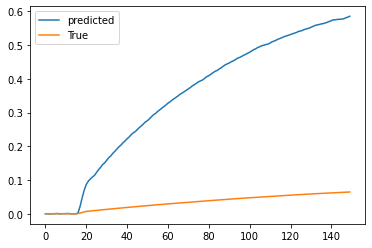

In [36]:
x,y = generate_xy(5)

x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()
inputs = Variable(x)
outputs = Variable(y)
pred = net(x)
print(pred, y)

AIF = np.load("MRI_other/TK_Modelling/AIF.npy")
t = np.arange(0,366,2.45)

i = 0

fitted_curve = TwoCUM(pred[i].detach().numpy(), t, AIF, 0)
fitted_curve1 = TwoCUM(y[i].detach().numpy(), t, AIF, 0)

plt.plot(fitted_curve, label = 'predicted')

plt.plot(fitted_curve1, label = 'True')
plt.legend()
plt.show()


In [8]:
"""
It seems like the problem at hand is more like trying to solve differential equations using neural nets.
I need to get the differential equation that governs this curve so i can create a custom loss function.
The loss function will minimise twocum fitting between the two predicted e val.
Maybe not because Pytorch needs to be able to backpropagate off it.
Possibly just replace all numpy functions with Pytorch ones and hope it works.
"""
AIF = np.load("data/AIF.npy")
t = np.arange(0,366,2.45)

AIF = torch.from_numpy(AIF)
t = torch.from_numpy(t)

E, Fp, vp = 0.1, 1e-5, 0.1
# E between 0 and 1
# FP blood flow
# vp between 0 and 1

#First calculate the parameter Tp
Tp=(vp/Fp)*(1-E)

#Calculate the IRF
exptTp= torch.exp(-1*t/Tp)

R=exptTp*(1-E) + E
#Calculate the convolution

print(R.shape, AIF.shape)
AIF1 = AIF.view(1, 1, -1)
R = torch.flip(R, (0,)).view(1, 1, -1)
print(R.shape, AIF.shape)
print(R.shape[0]-1)

print(AIF1.shape, R.shape, AIF.shape[0]-1)
temp = t[1]*torch.nn.functional.conv1d(AIF1, R, padding = AIF.shape[0]-1).view(-1)
# temp=np.convolve(AIF,R)*t[1]
print(temp.shape)
F=Fp*temp[0:len(t)]
print(F.shape)


torch.Size([150]) torch.Size([150])
torch.Size([1, 1, 150]) torch.Size([150])
0
torch.Size([1, 1, 150]) torch.Size([1, 1, 150]) 149
torch.Size([299])
torch.Size([150])


In [ ]:
#E, Fp, vp
#time spacings
t = np.arange(0,366,2.45)
batch_size = outputs[:,0].shape[0]
AIF = torch.from_numpy(np.load("data/AIF.npy"))
AIF1 = AIF.view(1, 1, -1) #reshaped for convolution


#For outputs
#First calculate the parameter Tp
outputs = torch.Tensor([[0.5, 2e-4, 0.5],[0.4, 2e-5, 0.3]])
E, Fp, vp
Tp=(vp/Fp)*(1-E)
#Calculate the IRF
exptTp= torch.exp(-1*t[:,None]/Tp[None,:]) #adding dummy variables so it divides properly

R=exptTp*(1-E) + E

#Calculate the convolution
R = torch.flip(R, (0,)).T #Reshape to fit the the convolution
R = torch.unsqueeze(R, 1)
temp = t[1]*torch.nn.functional.conv1d(AIF1, R, padding = AIF.shape[0]-1).view(batch_size, -1)
F_out = Fp.unsqueeze(-1)*temp[:,0:len(t)] #unsqueeze to match dimensions